# Using Data Science to Write Comedy
Note- If code is rerun, findings may be different.

#### By: 
#### Brandon Greenspan: [LinkedIn](https://https://www.linkedin.com/in/brandonlgreenspan) [Github](https://git.generalassemb.ly/bgreenspan)


### Table of Contents:
- [Problem Statement](#Problem-Statement)
- [Executive Summary](#Executive-Summary)
- [Data Collection](#Data-Collection)
- [Cleaning & EDA](##Cleaning-&-EDA)
- [Model Preparation](#Model-Preparation)
    - [Baseline Model](#Model-0:-Baseline)
    - [Train Test Split](#Train-Test-Split)
- [Modeling](#Modeling)
    - [Logistic Regression](#Model-1:-Logistic-Regression)
    - [Multinomial Naive Bayes](#Model-2:-Multinomial-Naive-Bayes)
    - [Gaussian Naive Bayes](#Model-3:-Gaussian-Naive-Bayes)
    - [KNN](#Model-4:-KNN)
    - [Support Vector Machine Model](Model-5:-SVM-Model)
- [Model Selection](#Model-Selection)
- [Model Evaluation](#Model-Evaluation)
- [Conclusion](#Conclusion)
    - [Recommendations](#Recommendations)
    - [Future Steps](#Future-Steps)
- [References](#References)


# Problem Statement


I am a comedy writer (True Story).  I've run out of my own original ideas, so in order to get a good idea to pitch to Mike Schur, I want to find common word choice/themes that fans of both The Good Place and Parks & Recreation are using.  In order to accomplish this, I will need to build a classification model.  While the success metric I'm aiming for in the model selection is accuracy, ultimately, my goal is to find the words that the model misclassifies in order to best identify the overlap of both shows that might indicate what elements a successful Mike Schur show would contain.  Ideally, I want the __accuracy rate of a selected model to be between 90% & 95%__, which means that my model should be a better predictor than the baseline model, but not too accurate because I actually need enough misclassification to come up with show ideas.  If the model theoretically did not misclassify any variables, then I would have an blank page, which is not an improvement upon how many comedic ideas I can conjure.

Before I get to meet Michael Schur, I have to present my process for showrunners at NBC, which is not a technical audience.

# Executive Summary

As I comedy writer, I'm only as good as my last script.  Unfortunately, I haven't written any good scripts, and I have accepted the fact that if I can't succeed with comedic talent, I can succeed with data.  Michael Schur had a lot of success with sitcoms like The Office, Parks & Rec, Brooklyn 99, The Good Place, and many more.  I have the ambitious goal to pitch a show idea to Michael Schur, while generating my show idea from data.

In order to generate a show that Michael Schur would want to develop, I will scrape the Subreddits for Parks & Rec and The Good Place to get an idea of what truly resonated with fans.  Data cleaning is fairly minimal since we are only working with Booleans and Strings, so we won't need to impute any string data.  To get a better understanding of our data, we will see how long our posts are as well as the most common words used for each Subreddit.  Out of these common words, we will create a custom stoplist for modeling.

After calculating our baseline model, we will run a Train, Test, Split for the purposes of training and testing any future models, and evaluating the accuracy scores of each model.  The classification models we build are Logistic Regression, Multinomial Naive Bayes, Gaussian Naive Bayes, KNN, & Support Vector Machine.  Since we will be using a gridsearch method for all of these models in order to finetune our hyperparameters, this does take some time to run.

Once we select a model, we will investigate our confusion matrix and assess the model's accuracy, sensitivity, specificity, precision, and true negative rates to get a sense as to the strength of the model beyond the initial accuracy score that led to its selection.  Then, we'll evaluate the strongest coefficients that the model is built on to see which words/phrases are the strongest predictors of a certain show.  Lastly, we'll dig into the words and phrases that most often lead to misclassification.

After looking at our misclassified words, we'll finally try to generate a sitcom idea.  Will the idea be enough to impress Mike Schur?

# Data Collection

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import time
import requests

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.base import TransformerMixin
from bs4 import BeautifulSoup

import regex as re

ignore: Warning


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


Data Collection will be done through the Pushshift API in order to scrape the subreddits for Parks & Rec and The Good Place.  The function will help automate the process in order for me to create two separate datafames- one for each show and then concatenate them into one database.

# Mahdi helped us build this code through his intro lesson
def query_pushshift(subreddit, kind = 'submission', day_window = 365, n = 14):
    SUBFIELDS = ['title', 'selftext', 'subreddit', 'created_utc',
                 'author', 'num_comments', 'score', 'is_self', 'is_original_content',
                'over_18','is_crosspostable']
    
    # establish base url and stem
    BASE_URL = f"https://api.pushshift.io/reddit/search/{kind}" # also known as the "API endpoint" 
    stem = f"{BASE_URL}?subreddit={subreddit}&size=500" # always pulling max of 500
    
    # instantiate empty list for temp storage
    posts = []
    
    # implement for loop with `time.sleep(2)`
    for i in range(1, n + 1):
        URL = "{}&after={}d".format(stem, day_window * i)
        print("Querying from: " + URL)
        response = requests.get(URL)
        assert response.status_code == 200
        mine = response.json()['data']
        df = pd.DataFrame.from_dict(mine)
        posts.append(df)
        time.sleep(2) # required time as listed by the robots page
    
    # pd.concat storage list
    full = pd.concat(posts, sort=False)
    
    # if submission
    if kind == "submission":
        # select desired columns
        full = full[SUBFIELDS]
        # drop duplicates
        full.drop_duplicates(inplace = True)
        # select `is_self` == True
        full = full.loc[full['is_self'] == True]

    # create `timestamp` column
    full['timestamp'] = full["created_utc"].map(dt.date.fromtimestamp)
    
    print("Query Complete!")    
    return full 

## Reading in CSVs

In [2]:
good_place_df = pd.read_csv('./goodplace.csv')

In [3]:
good_place_df.shape

(1019, 12)

In [4]:
parks_and_rec_df = pd.read_csv('./parksandrecs.csv')

In [5]:
parks_and_rec_df.shape

(1081, 12)

After trying different values for day_window, n, and size, I wanted to ensure that I had enough data (over 500 rows for each show) and that my classes were relatively balanced.  There weren't nearly as many submissions as I expected for each page, so I decided to scrape 14 years worth of data (the age of Reddit).  This is also interesting to note because the shows did not overlap in timeframe, and considering humor changes with time, it will be interesting to see what words/phrases misclassify due to changes in taste over time.  My classes look balanced (1081 v. 1019, with Parks & Rec being my majority class), so I'm ready to proceed to cleaning.  I have also exported the data into csvs in case my second test run would like to be duplicated.

# Cleaning & EDA

In [6]:
df = pd.concat([parks_and_rec_df, good_place_df], ignore_index = True)

Concatenated both subreddits into one database.  Checking my head and tail to ensure it was successful

In [7]:
df.head(3)

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,is_original_content,over_18,is_crosspostable,timestamp
0,Small detain I noticed (not sure if anyone did...,On like my 3rd watch through. Will Arnett must...,PandR,1556457656,michaelskarn007,3,0,True,False,False,True,2019-04-28
1,"How many Lowe’s could Rob Lowe rob, if Rob Low...",NaN,PandR,1556466443,spiritofgonzo1,0,27,True,False,False,True,2019-04-28
2,Andy is peter quill,Wouldn’t it be funny if at the end of end game...,PandR,1556481813,Pawandynee,2,0,True,False,False,True,2019-04-28


In [8]:
df.tail(3)

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,is_original_content,over_18,is_crosspostable,timestamp
2097,[SPOILER] Janet Theory,Please do not read this if you haven't watched...,TheGoodPlace,1491858194,BrianFoxShow,10,42,True,NaN,False,NaN,2017-04-10
2098,Is Janet Allegorical? [spoiler],Since my Janet is god theory didn't resonate -...,TheGoodPlace,1491921533,kdubstep,5,3,True,NaN,False,NaN,2017-04-11
2099,Having just finished the (amazing) first seaso...,That pizza is DEFINITELY gluten-free.,TheGoodPlace,1492246895,weblowinherseys,4,40,True,NaN,False,NaN,2017-04-15


Checked head and tail to ensure the data properly went to one dataframe, which it did.  Now checking for null values.

In [9]:
df.isnull().sum()

title                     0
selftext                164
subreddit                 0
created_utc               0
author                    0
num_comments              0
score                     0
is_self                   0
is_original_content    1490
over_18                   0
is_crosspostable       1155
timestamp                 0
dtype: int64

In [10]:
df.dtypes

title                  object
selftext               object
subreddit              object
created_utc             int64
author                 object
num_comments            int64
score                   int64
is_self                  bool
is_original_content    object
over_18                  bool
is_crosspostable       object
timestamp              object
dtype: object

We have a lot of nulls in original content, and crosspostable.  These are Boolean categories that can be later be turned into binomials, so I'm going to dig a little deeper into the values into that.

In [11]:
df['is_original_content'].value_counts()

False    610
Name: is_original_content, dtype: int64

No need to keep original content column, since there are no True values.  If every row would hold the same value, then it is unimportant to help differentiate for our target variable.

In [12]:
df.drop(columns = ['is_original_content'], inplace = True)

In [13]:
df['is_crosspostable'].value_counts()

True     896
False     49
Name: is_crosspostable, dtype: int64

I am going to impute my null values as False.  Which will later be turned into a binomial.  I can assume a null value is equivalent to "not true," so I find this imputation to be justified.

In [14]:
df.fillna('False', inplace = True)

In [15]:
df['over_18'] = df['over_18'].astype(str).replace({
    'False' : '0',
    'True' : '1'
}).astype(int) 
'''type is Boolean, while I could have used mapping, I decided to convert booleans to strings, 
assign my values, then change the type to integer'''
df['is_self'] = df['is_self'].astype(str).replace({
    'False' : '0',
    'True' : '1'
}).astype(int)
df['is_crosspostable'] = df['is_crosspostable'].astype(str).replace({
    'False' : '0',
    'True' : '1'
}).astype(int)

All null values have be handled and boolean categories have been converted to binomial values.

In [16]:
df.describe()

,created_utc,num_comments,score,is_self,over_18,is_crosspostable
count,2.100000e+03,2100.000000,2100.000000,2100.0,2100.000000,2100.000000
mean,1.475290e+09,10.367143,25.894762,1.0,0.007143,0.426667
std,6.880685e+07,34.101018,77.697823,0.0,0.084233,0.494711
min,1.295516e+09,0.000000,0.000000,1.0,0.000000,0.000000
25%,1.434767e+09,2.000000,2.000000,1.0,0.000000,0.000000
50%,1.495146e+09,5.000000,8.000000,1.0,0.000000,0.000000
75%,1.525667e+09,11.000000,20.000000,1.0,0.000000,1.000000
max,1.561222e+09,887.000000,1310.000000,1.0,1.000000,1.000000


All values of is_self are 1, so I will drop that.  over_18 is a very imbalanced class, with only .7% having a true value, so I will drop that column too, especially considering that the shows themselves are not 18 and over shows.

In [17]:
df.drop(columns = ['is_self', 'over_18'], inplace = True)

In [18]:
df['subreddit'].value_counts()

PandR           1081
TheGoodPlace    1019
Name: subreddit, dtype: int64

PandR (Parks & Rec) is my majority class and therefore my future baseline model.  Going to turn this into a binomial with PandR set to 1 and TheGoodPlace set to 0.

In [19]:
df['PandR_subr'] = df['subreddit'].astype(str).replace({
    'TheGoodPlace' : '0',
    'PandR' : '1'
}).astype(int)
df.drop(columns = ['subreddit']).head()
# my binomial column is replacing the original subreddit column since that has now been turned into numerical values

,title,selftext,created_utc,author,num_comments,score,is_crosspostable,timestamp,PandR_subr
0,Small detain I noticed (not sure if anyone did...,On like my 3rd watch through. Will Arnett must...,1556457656,michaelskarn007,3,0,1,2019-04-28,1
1,"How many Lowe’s could Rob Lowe rob, if Rob Low...",False,1556466443,spiritofgonzo1,0,27,1,2019-04-28,1
2,Andy is peter quill,Wouldn’t it be funny if at the end of end game...,1556481813,Pawandynee,2,0,1,2019-04-28,1
3,Champion song?,"I know I'm not imagining it, but I can't find ...",1556500237,awesometoenails,5,1,1,2019-04-28,1
4,Sorry if this has been done here before but I ...,Um Leslie? I typed your symptoms into the thin...,1556650836,Cheerio419,18,14,1,2019-04-30,1


In [20]:
df['all_text'] = df['title'] + " " + df['selftext'] + " " + df['author']
df.drop(columns = ['title', 'selftext', 'author'], inplace = True)

Merged all text into one column since I will be using CountVectorizer in EDA.

In [21]:
list_of_strings = df['all_text']

Now I will run all of the text through CountVectorizer to create a matrix to get a better sense of word(s) count.

In [22]:
cvec = CountVectorizer(lowercase = True, # turn everything to lower case
                       ngram_range = (1,2)) # for EDA, I will look at 1 word and 2 word phrases

# data run through cvec must be transformed
X_text = cvec.fit_transform(list_of_strings)

In [23]:
X_text_df = pd.DataFrame(X_text.toarray(),
                      columns = cvec.get_feature_names())

X_text_df.head()

,00,00 made,00 min,000,000 000,000 605,000 candles,000 days,000 for,000 how,...,zynerd,zzesty,宀宀분당건마,宀宀분당건마 양재오피,분당키스방,분당키스방 제이제이45다컴,양재오피,양재오피 분당키스방,제이제이45다컴,제이제이45다컴 removed
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


This takes the text I've run through CountVectorizer and turned it into a matrix, representing the word/2-word count by document.  I notice that the last few columns are not in English.  I'm going to remove the columns that aren't in English.  This is not to say that the comments aren't valid, but interpretability of any model would be hard to explain if I don't speak the language.

In [24]:
X_text_df.drop(columns = ['宀宀분당건마', '宀宀분당건마 양재오피', '분당키스방', '분당키스방 제이제이45다컴', '양재오피', '양재오피 분당키스방', '제이제이45다컴', '제이제이45다컴 removed'], inplace = True)


While my next steps will seem like a duplication of efforts, I first want to further visualize what words appear frequently in both Parks and Rec & The Good Place.  I then would like to find the overlap of top words used for both shows in order to create a custom stoplist for modeling purposes.  First, let's see how long the post length is for our text.

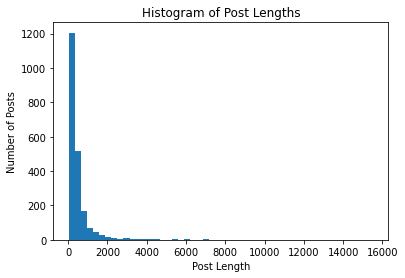

In [25]:
lengths_of_posts = [len(each) for each in df['all_text']]
plt.hist(lengths_of_posts, bins = 50)
plt.title('Histogram of Post Lengths')
plt.xlabel('Post Length')
plt.ylabel('Number of Posts');

Most of our posts are under 1000 words.  Since a post can't have fewer than 0 words, there is an obvious right skew.  We likely see our peak close to 0 because of posts that would contain of mostly images.

In [26]:
X_text_df['PandR_subr'] = df['PandR_subr']

Now,let's create separate dataframes for Parks & Rec and The Good Place to evaluate the most common words in each show's Subreddit.

In [27]:
pr_words_df = pd.DataFrame(X_text_df.loc[X_text_df['PandR_subr'] != 0].sum().sort_values(ascending = False))

pr_words_df.drop(index = ['PandR_subr'], inplace = True)

pr_words_df.columns = ['pr_word_count']

pr_words_df.head()

,pr_word_count
the,2890
and,1972
to,1633
of,1217
it,1073


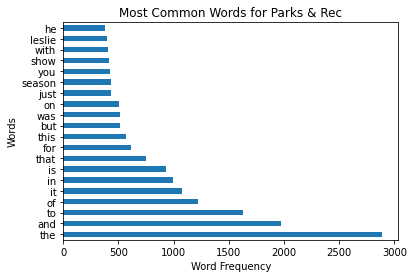

In [28]:
pr_words_df.head(20).plot(kind = 'barh', legend = None)
plt.title('Most Common Words for Parks & Rec')
plt.xlabel('Word Frequency')
plt.ylabel('Words');

The most common words mostly consist of words that would be filtered out by sklearn's list of English stop words.  The noticeable exception is leslie, the main character of the show, who appears in the top 20 most frequent words for the Parks & Rec subreddit.

In [29]:
#repeating same process for The Good Place
gp_words_df = pd.DataFrame(X_text_df.loc[X_text_df['PandR_subr'] == 0].sum().sort_values(ascending = False))

gp_words_df.columns = ['gp_word_count']

gp_words_df.drop(index = ['PandR_subr'], inplace = True)

gp_words_df.head()

,gp_word_count
the,5774
to,3036
and,2441
of,2064
that,1865


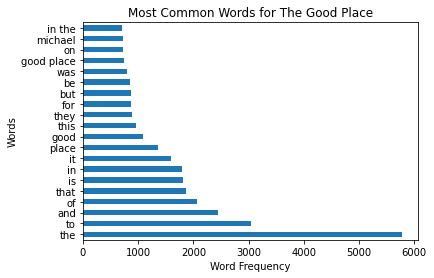

In [30]:
gp_words_df.head(20).plot(kind = 'barh', legend = None)
plt.title('Most Common Words for The Good Place')
plt.xlabel('Word Frequency')
plt.ylabel('Words');

Similar to Parks & Rec, The most common words for The Good Place's Subreddit would also qualify as "stop words."  Also similarly, Michael (one of the main characters for The Good Place) is also listed as a common word, along with the show's name.  My next steps is to evaluate the word count overall, so let's join the dataframes and create another visual.

In [31]:
word_count_df = pr_words_df.join(gp_words_df)

word_count_df

,pr_word_count,gp_word_count
the,2890,5774
and,1972,2441
to,1633,3036
of,1217,2064
it,1073,1596
...,...,...
hugh,0,1
hugged the,0,1
hugged,0,1
huge wrench,0,1


In [32]:
word_count_df['total_count'] = word_count_df['pr_word_count'] + word_count_df['gp_word_count']
# adds a new column, adding up the word counts for each show
word_count_df

,pr_word_count,gp_word_count,total_count
the,2890,5774,8664
and,1972,2441,4413
to,1633,3036,4669
of,1217,2064,3281
it,1073,1596,2669
...,...,...,...
hugh,0,1,1
hugged the,0,1,1
hugged,0,1,1
huge wrench,0,1,1


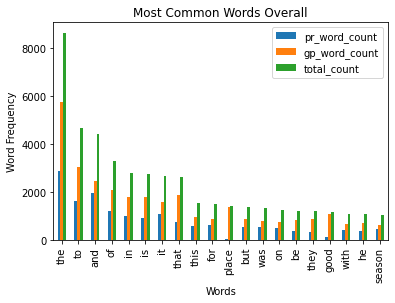

In [33]:
word_count_df.sort_values(by = ['total_count'], ascending = False).head(20).plot(kind = 'bar')
plt.title('Most Common Words Overall')
plt.xlabel('Words')
plt.ylabel('Word Frequency');

This shows the overall word count for our entire dataframe.  While these are unsuprisingly stop words, it's interesting to note that all of these top 20 terms appear with greater frequency in The Good Place.  When looking back over the common words by show, I do notice that the scale is different for each graph, which is more conveniently displayed via this graph above.  Since we've already found the common words, I want to be proactive and set up a stop words list for any future modeling.

In [34]:
pr_words = X_text_df.loc[X_text_df['PandR_subr'] != 0].sum().sort_values(ascending = False).head(101).index
# Generates a top 100 list for most common Parks & Rec words
pr_words = pr_words.drop('PandR_subr') 
# Since it was adding up the count for the dummy column, I had to drop it, so the subreddit name doesn't factor into the model

pr_words

Index(['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this',
       'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'leslie',
       'he', 'so', 'be', 'my', 'have', 'like', 'ron', 'they', 'parks', 'or',
       'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as',
       'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not',
       'would', 'one', 'know', 'has', 'deleted', 'parks and', 'andy',
       'the show', 'anyone', 'his', 'up', 'out', 'we', 'an', 'com', 'time',
       'ben', 'think', 'april', 'where', 'rec', 'how', 'get', 'watch',
       'and rec', 'really', 've', 'do', 'http', 'does', 'watching', 'who',
       'amp', 'tom', 'any', 'him', 'first', 'some', 'love', 'character',
       'find', 'chris', 'don', 'series', 'did', 'by', 'for the', 'pawnee',
       'been', 'false', 'ann', 'now', 'after'],
      dtype='object')

Office is a top term!  This is most likely referring to the other hit show, The Office, which Parks & Rec often gets compared to, which is likely happening frequently on Reddit.

In [35]:
gp_words = X_text_df.loc[X_text_df['PandR_subr'] == 0].sum().sort_values(ascending = False).head(100).index
# Replicate the process for The Good Place
gp_words

Index(['the', 'to', 'and', 'of', 'that', 'is', 'in', 'it', 'place', 'good',
       'this', 'they', 'for', 'but', 'be', 'was', 'good place', 'on',
       'michael', 'in the', 'he', 'with', 'bad', 'so', 'eleanor', 'have',
       'she', 'the good', 'season', 'we', 'as', 'if', 'are', 'you', 'not',
       'what', 'just', 'all', 'show', 'of the', 'her', 'about', 'like',
       'there', 'or', 'would', 'bad place', 'chidi', 'people', 'can', 'at',
       'how', 'think', 'from', 'out', 'the bad', 'my', 'one', 'to the', 'his',
       'janet', 'know', 'when', 'them', 'will', 'episode', 'up', 'because',
       'do', 'has', 'by', 'an', 'the show', 'get', 'me', 'their', 'who',
       'jason', 'to be', 'tahani', 'other', 'really', 'time', 'why', 'only',
       'first', 'more', 'been', 'could', 'even', 'being', 'no', 'were',
       'spoilers', 'some', 'see', 'also', 'don', 'into', 'had'],
      dtype='object')

In [36]:
all_words = list(gp_words) + list(pr_words)
# creates a master list of the top 100 terms for both shows
stops = pd.DataFrame(all_words)

custom_stopwords = stops.loc[stops.duplicated() == True]
# finds the words that appear in the top 100 for both shows
stopwords = list(custom_stopwords[0])
# turns those words into a stop word list to utilize in model testing
stopwords

['the',
 'and',
 'to',
 'of',
 'it',
 'in',
 'is',
 'that',
 'for',
 'this',
 'but',
 'was',
 'on',
 'just',
 'season',
 'you',
 'show',
 'with',
 'he',
 'so',
 'be',
 'my',
 'have',
 'like',
 'they',
 'or',
 'can',
 'what',
 'me',
 'episode',
 'of the',
 'at',
 'are',
 'she',
 'as',
 'all',
 'in the',
 'about',
 'there',
 'from',
 'if',
 'her',
 'when',
 'not',
 'would',
 'one',
 'know',
 'has',
 'the show',
 'his',
 'up',
 'out',
 'we',
 'an',
 'time',
 'think',
 'how',
 'get',
 'really',
 'do',
 'who',
 'first',
 'some',
 'don',
 'by',
 'been']

# Model Preparation

For all of our models, we are trying to use X (text from subreddit submissions) in order to  to predict y (whether a submission belongs in Parks & Rec or not).

In [37]:
X = df['all_text'] #predictive variable
y = df['PandR_subr'] #target variable

## Model 0: Baseline

In [38]:
baseline = df['PandR_subr'].mean()
baseline

0.5147619047619048

Our baseline model would predict the majority class (Parks & Rec) every single time.  Since 51% of our y values are listed as Parks & Rec, our model would only be accurate 51% of the time.  While I want some misclassification, misclassifying almost 50% of the data is too much for me to go through in order to generate ideas for a show.  It's almost the same effect as having a model that has 100% accuracy in that I'll just continue to have writers block.  We need to build a better classification model.

## Train Test Split

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state = 63,
                                                    stratify = y # keeps the ratio the same for our train and test
                                                   )

# Modeling

## Model 1: Logistic Regression

In [60]:
pipe = Pipeline([ #instantiate transformers and model
    ('vectorizer', CountVectorizer()), 
    ('tfidf', TfidfTransformer()),
    ('lr', LogisticRegression(random_state = 63))
])

# set hyperparameters

pipe_params = {'vectorizer__ngram_range'  : [(1,1),(1,2), (1,3)],
              'vectorizer__stop_words': [None, 'english', stopwords], #including cusotm stopwords in addition to english and none
              'tfidf__use_idf'  : [True, False], #toggle between use of TFIDF
              'lr__solver': ['liblinear', 'lbfgs'],
              'lr__penalty': ['l1', 'l2', 'none'] # running this with the lasso and ridge techniques by applying a penalty, also running with no penalty
              }

gs = GridSearchCV(pipe,
                 param_grid = pipe_params,
                 cv = 5, # cross validation of 5
                 scoring = 'accuracy')

Since I want to try to get the best result for our Logistic Regression model, I set up a gridsearch to run 540 possible models in order to return the best fit.  For hyperparameters, we looked at 1-grams, 2-grams, and 3-grams.  We tried with my custom stopwords, english stopwords, and no stopwords.  We tried it both with and and without the use of tfidf, 2 different solvers, and and also tried applying a lasso penalty, ridge penalty, or no penalty.  Each model went through a 5-fold cross-validation.

In [61]:
lr_fit = gs.fit(X_train,y_train)

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'n

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'n

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: penalty='none' is not supported for the liblinear solver

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: penalty='none' is not supported for the liblinear solver

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: penalty='none' is not supported for the liblinear solver

  F

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: penalty='none' is not supported for the liblinear solver

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: penalty='none' is not supported for the liblinear solver

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: penalty='none' is not supported for the liblinear solver

  F

In [62]:
lr_fit.score(X_train, y_train)

1.0

In [63]:
lr_fit.score(X_test, y_test)

0.9352380952380952

In [64]:
cross_val_score(lr_fit.best_estimator_, X, y).mean()

0.9223809523809523

In [65]:
lr_fit.best_params_

{'lr__penalty': 'none',
 'lr__solver': 'lbfgs',
 'tfidf__use_idf': True,
 'vectorizer__ngram_range': (1, 1),
 'vectorizer__stop_words': 'english'}

Our best Logistic Regression model involved no penalty, the "lbfgs" solver, use of TFIDF, an ngram range of (1,1), and sklearn's English stop words.  This model was overfit since it had a perfect training score, but a .94 testing score.  Our lower cross-validation score compared to test score shows that our model might not perform as well against unseen data as it did against our test data.  This is a significant improvement from our baseline model of .51, but we can still try to achieve better accuracy.

I would like to try a Naive Bayes model on this data to see if we can improve accuracy.  Since I want to try models with and without TFIDF, I will have to build a Multinomial Naive Bayes model for my tests without TFIDF and then build a Gaussian Naive Bayes model for running TFIDF.  First, let's try our Multinomial Naive Bayes model.

## Model 2: Multinomial Naive Bayes

In [66]:
pipe = Pipeline([ # instantiate
    ('vectorizer', CountVectorizer()),
    ('mnb', MultinomialNB())
])

# set hyperparameters

pipe_params = {'vectorizer__ngram_range'  : [(1,1),(1,2), (1,3)],
              'vectorizer__stop_words': [None, 'english', stopwords],
              'mnb__alpha': [.12, .125, .13] #tested out other alpha values and got it narrowed to this
              }

gsnb = GridSearchCV(pipe,
                 param_grid = pipe_params,
                 cv = 5,
                 scoring = 'accuracy',
                 verbose = 2 # let's get progress updates in real time this time
                   )

To get the best result for the Multinomial Naive Bayes model, I set up a gridsearch to run 135 possible models in order to return the best fit.  For hyperparameters, we looked at 1-grams, 2-grams, and 3-grams.  We tried with my custom stopwords, english stopwords, and no stopwords.  Lastly, we tried adjusting our alpha valaues and reran this many times before settling on the values we chose.  Each model went through a 5-fold cross-validation.

In [67]:
mnb_fit = gsnb.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] mnb__alpha=0.12, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  mnb__alpha=0.12, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.3s
[CV] mnb__alpha=0.12, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  mnb__alpha=0.12, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.2s
[CV] mnb__alpha=0.12, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 
[CV]  mnb__alpha=0.12, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.2s
[CV] mnb__alpha=0.12, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 
[CV]  mnb__alpha=0.12, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.2s
[CV] mnb__alpha=0.12, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 
[CV]  mnb__alpha=0.12, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.2s
[CV] mnb__alpha=0.12, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 
[CV]  mnb__alpha=0.12, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, total=   0.2s
[CV] mnb__alpha=0.12, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 
[CV]  mnb__alpha=0.12, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english,

[CV]  mnb__alpha=0.12, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   0.4s
[CV] mnb__alpha=0.12, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 
[CV]  mnb__alpha=0.12, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   0.4s
[CV] mnb__alpha=0.12, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 
[CV]  mnb__alpha=0.12, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   0.4s
[CV] mnb__alpha=0.12, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 
[CV]  mnb__alpha=0.12, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   0.4s
[CV] mnb__alpha=0.12, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 
[CV]  mnb__alpha=0.12, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   0.4s
[CV] mnb__alpha=0.12, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but',

[CV]  mnb__alpha=0.12, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, total=   0.6s
[CV] mnb__alpha=0.12, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'] 
[CV]  mnb__alpha=0.12, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'al

[CV]  mnb__alpha=0.125, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.2s
[CV] mnb__alpha=0.125, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', '

[CV]  mnb__alpha=0.125, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.5s
[CV] mnb__alpha=0.125, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', '

[CV]  mnb__alpha=0.125, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.7s
[CV] mnb__alpha=0.125, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', '

[CV]  mnb__alpha=0.13, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.2s
[CV] mnb__alpha=0.13, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'kn

[CV]  mnb__alpha=0.13, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.5s
[CV] mnb__alpha=0.13, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 
[CV]  mnb__alpha=0.13, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   1.6s
[CV] mnb__alpha=0.13, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 
[CV]  mnb__alpha=0.13, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   1.6s
[CV] mnb__alpha=0.13, vectorizer__ngram_range=(1, 3), ve

[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:  1.2min finished


In [68]:
mnb_fit.best_params_

{'mnb__alpha': 0.12,
 'vectorizer__ngram_range': (1, 2),
 'vectorizer__stop_words': 'english'}

In [69]:
mnb_fit.score(X_train, y_train)

1.0

In [70]:
mnb_fit.score(X_test, y_test)

0.9352380952380952

In [71]:
cross_val_score(mnb_fit.best_estimator_, X, y).mean()

0.9261904761904762

Our best fit involed an alpha of .12, ngram range of (1,2), and the sklearn English stop words.  This model was overfit because it had a perfect training score and a 0.93 testing score.  The 0.94 testing score is still significantly more accutate as our baseline model.  Our lower cross-validation score shows that our model may not perform as well against unseen data as it did against our test data since the testing score was higher than the cross-validation score.  Next, I want to see how TFIDF would perform with a Naive Bayes model, so I need to try a Gaussian Naive Bayes.

## Model 3: Gaussian Naive Bayes

In [72]:
class DenseTransformer(TransformerMixin): #from Mahdi
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.toarray()


A dense transformer is required in order for the Gaussian Naive Bayes model to run properly.

In [73]:
pipe = Pipeline([ #instantiate transformers and model
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('_', DenseTransformer()),
    ('gnb', GaussianNB())
])

# set hyperparameters

pipe_params = {'vectorizer__ngram_range'  : [(1,1),(1,2), (1,3)],
              'vectorizer__stop_words': [None, 'english', stopwords],
              'tfidf__use_idf'  : [True, False]
              }

gsgnb = GridSearchCV(pipe,
                 param_grid = pipe_params,
                 cv = 5,
                 scoring = 'accuracy',
                 verbose = 2
                   )

Since I want to try to get the best result for our Gaussian Naive Bayes model, I set up a gridsearch to run 90 possible models in order to return the best fit.  For hyperparameters, we looked at 1-grams, 2-grams, and 3-grams.  We tried with my custom stopwords, english stopwords, and no stopwords.  We tried it both with and and without the use of tfidf.  Each model went through a 5-fold cross-validation.

In [74]:
gnb_fit = gsgnb.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.6s
[CV] tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.6s
[CV] tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 
[CV]  tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.6s
[CV] tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 
[CV]  tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.6s
[CV] tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 
[CV]  tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.7s
[CV] tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 
[CV]  tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, total=   0.7s
[CV] tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 
[CV]  tfidf__use_idf=True, vectorizer__ngram_r

[CV]  tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   3.5s
[CV] tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 
[CV]  tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   2.6s
[CV] tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 
[CV]  tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   2.6s
[CV] tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 
[CV]  tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   2.7s
[CV] tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 
[CV]  tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   2.7s
[CV] tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 
[CV]  tfidf__use_idf=True, v

[CV]  tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, total=   4.4s
[CV] tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 
[CV]  tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, total=   4.3s
[CV] tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 
[CV]  tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, total=   4.2s
[CV] tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'ge

[CV]  tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.5s
[CV] tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 

[CV]  tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   2.6s
[CV] tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 

[CV]  tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   5.3s
[CV] tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  4.8min finished


In [75]:
gnb_fit.best_params_

{'tfidf__use_idf': False,
 'vectorizer__ngram_range': (1, 3),
 'vectorizer__stop_words': 'english'}

In [76]:
gnb_fit.score(X_train, y_train)

1.0

In [77]:
gnb_fit.score(X_test, y_test)

0.8876190476190476

In [78]:
cross_val_score(gnb_fit.best_estimator_, X, y).mean()

0.8714285714285713

Our best fit didn't include the use of TFIDF, which is surprising, since the Gaussian model is usually better fit for float values generated by TFIDF.  This model also found the ngram range of (1,3) and sklearn's English stopwords most effective.

Since the best model here didn't involve the use of TFIDF, it's no surprise that the Gaussian Naive Bayes model was less accurate than our Multinomial Naive Bayes.

This model was overfit because it had a perfect training score with a lesser testing score of 0.89.  This testing score is still higher than our baseline model.  Our cross-validation score shows that our model may not perform as well against unseen data as it did against our test data since the testing score was higher than the cross-validation score.  While the Multinomial Naive Bayes model is certainly our more effective Naive Bayes model, I feel as is all classification problems should attempt to fit a KNN model, so I will set that up.

## Model 4: KNN

In [79]:
pipe = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('knn', KNeighborsClassifier())])

# set hyperparameters

pipe_params = {'vectorizer__ngram_range'  : [(1,1),(1,2), (1,3)],
              'vectorizer__stop_words': [None, 'english', stopwords],
              'tfidf__use_idf'  : [True, False],
              'knn__n_neighbors': [3,5,9],
              'knn__weights' : ['uniform', 'distance'], # distance gives more predictive power to closer neighbors
               'knn__p': [1,2,'p'] # allows us to test Minkowski, Euclidean, and Manhattan measurements
               
              }

gsknn = GridSearchCV(pipe,
                 param_grid = pipe_params,
                 cv = 5,
                 scoring = 'accuracy',
                 verbose = 2   
                    )

Since I want to try to get the best result for our KNN model, I set up a gridsearch to run 2120 possible models (this took a little time) in order to return the best fit.  For hyperparameters, we looked at 1-grams, 2-grams, and 3-grams.  We tried with my custom stopwords, english stopwords, and no stopwords.  We tried it both with and and without the use of tfidf.  We also tried running it by looking at the closest 3,5, and 9 neighbors, tried it by weighting and not-weighting neighbor distance, all with the Euclidean, Minkowski, and Mahattan metrics.

Each model went through a 5-fold cross-validation.

In [80]:
knn_fit = gsknn.fit(X_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV] knn__n_neighbors=3, knn__p=1, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  knn__n_neighbors=3, knn__p=1, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.3s
[CV] knn__n_neighbors=3, knn__p=1, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  knn__n_neighbors=3, knn__p=1, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.4s
[CV] knn__n_neighbors=3, knn__p=1, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=3, knn__p=1, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.3s
[CV] knn__n_neighbors=3, knn__p=1, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=3, knn__p=1, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.3s
[CV] knn__n_neighbors=3, knn__p=1, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=3, knn__p=1, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer

[CV]  knn__n_neighbors=3, knn__p=1, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.4s
[CV] knn__n_neighbors=3, knn__p=1, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=3, knn__p=1, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.9s
[CV] knn__n_neighbors=3, knn__p=1, knn__weights=uniform, tfidf__use_i

[CV]  knn__n_neighbors=3, knn__p=1, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.5s
[CV] knn__n_neighbors=3, knn__p=1, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=3, knn__p=1, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   1.2s
[CV] knn__n_neighbors=3, knn__p=1, knn__weights=uniform, tfidf__use_i

[CV]  knn__n_neighbors=3, knn__p=1, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.8s
[CV] knn__n_neighbors=3, knn__p=1, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=3, knn__p=1, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.3s
[CV] knn__n_neighbors=3, knn__p=1, knn__weights=uniform, tfidf__use

[CV]  knn__n_neighbors=3, knn__p=1, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.3s
[CV] knn__n_neighbors=3, knn__p=1, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=3, knn__p=1, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.6s
[CV] knn__n_neighbors=3, knn__p=1, knn__weights=uniform, tfidf__us

[CV]  knn__n_neighbors=3, knn__p=1, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.5s
[CV] knn__n_neighbors=3, knn__p=1, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=3, knn__p=1, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   1.2s
[CV] knn__n_neighbors=3, knn__p=1, knn__weights=uniform, tfidf__us

[CV]  knn__n_neighbors=3, knn__p=1, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.7s
[CV] knn__n_neighbors=3, knn__p=1, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=3, knn__p=1, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.3s
[CV] knn__n_neighbors=3, knn__p=1, knn__weights=distance, tfidf__u

[CV]  knn__n_neighbors=3, knn__p=1, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.2s
[CV] knn__n_neighbors=3, knn__p=1, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=3, knn__p=1, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.6s
[CV] knn__n_neighbors=3, knn__p=1, knn__weights=distance, tfidf__u

[CV]  knn__n_neighbors=3, knn__p=1, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.5s
[CV] knn__n_neighbors=3, knn__p=1, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=3, knn__p=1, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   1.2s
[CV] knn__n_neighbors=3, knn__p=1, knn__weights=distance, tfidf__u

[CV]  knn__n_neighbors=3, knn__p=1, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.8s
[CV] knn__n_neighbors=3, knn__p=1, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=3, knn__p=1, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.3s
[CV] knn__n_neighbors=3, knn__p=1, knn__weights=distance, tfidf_

[CV]  knn__n_neighbors=3, knn__p=1, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.2s
[CV] knn__n_neighbors=3, knn__p=1, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=3, knn__p=1, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.6s
[CV] knn__n_neighbors=3, knn__p=1, knn__weights=distance, tfidf

[CV]  knn__n_neighbors=3, knn__p=1, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.5s
[CV] knn__n_neighbors=3, knn__p=1, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=3, knn__p=1, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   1.2s
[CV] knn__n_neighbors=3, knn__p=1, knn__weights=distance, tfidf

[CV]  knn__n_neighbors=3, knn__p=1, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.9s
[CV] knn__n_neighbors=3, knn__p=2, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=3, knn__p=2, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.2s
[CV] knn__n_neighbors=3, knn__p=2, knn__weights=uniform, tfidf__use

[CV]  knn__n_neighbors=3, knn__p=2, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.2s
[CV] knn__n_neighbors=3, knn__p=2, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=3, knn__p=2, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.6s
[CV] knn__n_neighbors=3, knn__p=2, knn__weights=uniform, tfidf__use_i

[CV]  knn__n_neighbors=3, knn__p=2, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.5s
[CV] knn__n_neighbors=3, knn__p=2, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=3, knn__p=2, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   1.2s
[CV] knn__n_neighbors=3, knn__p=2, knn__weights=uniform, tfidf__use_i

[CV]  knn__n_neighbors=3, knn__p=2, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.6s
[CV] knn__n_neighbors=3, knn__p=2, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=3, knn__p=2, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.2s
[CV] knn__n_neighbors=3, knn__p=2, knn__weights=uniform, tfidf__use

[CV]  knn__n_neighbors=3, knn__p=2, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.5s
[CV] knn__n_neighbors=3, knn__p=2, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=3, knn__p=2, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.5s
[CV] knn__n_neighbors=3, knn__p=2, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=3, knn__p=2, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.5s
[CV] knn__n_neighbors=3, knn__p=2, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=3, knn__p=2, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vec

[CV]  knn__n_neighbors=3, knn__p=2, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.4s
[CV] knn__n_neighbors=3, knn__p=2, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=3, knn__p=2, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   1.0s
[CV] knn__n_neighbors=3, knn__p=2, knn__weights=uniform, tfidf__us

[CV]  knn__n_neighbors=3, knn__p=2, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.7s
[CV] knn__n_neighbors=3, knn__p=2, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=3, knn__p=2, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.2s
[CV] knn__n_neighbors=3, knn__p=2, knn__weights=distance, tfidf__u

[CV]  knn__n_neighbors=3, knn__p=2, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.2s
[CV] knn__n_neighbors=3, knn__p=2, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=3, knn__p=2, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.6s
[CV] knn__n_neighbors=3, knn__p=2, knn__weights=distance, tfidf__u

[CV]  knn__n_neighbors=3, knn__p=2, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.4s
[CV] knn__n_neighbors=3, knn__p=2, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=3, knn__p=2, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   1.0s
[CV] knn__n_neighbors=3, knn__p=2, knn__weights=distance, tfidf__u

[CV]  knn__n_neighbors=3, knn__p=2, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.6s
[CV] knn__n_neighbors=3, knn__p=2, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=3, knn__p=2, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.1s
[CV] knn__n_neighbors=3, knn__p=2, knn__weights=distance, tfidf_

[CV]  knn__n_neighbors=3, knn__p=2, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.5s
[CV] knn__n_neighbors=3, knn__p=2, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=3, knn__p=2, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.5s
[CV] knn__n_neighbors=3, knn__p=2, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=3, knn__p=2, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.5s
[CV] knn__n_neighbors=3, knn__p=2, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=3, knn__p=2, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 

[CV]  knn__n_neighbors=3, knn__p=2, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.4s
[CV] knn__n_neighbors=3, knn__p=2, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=3, knn__p=2, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   1.0s
[CV] knn__n_neighbors=3, knn__p=2, knn__weights=distance, tfidf

[CV]  knn__n_neighbors=3, knn__p=2, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.6s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.1s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.1s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.1s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.1s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.1s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, total=   0.1s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 
[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, total=   0.1s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, total=   0.1s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 
[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, total=   0.1s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, total=   0.1s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'] 
[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on'

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.1s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at'

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.1s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at'

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.4s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.4s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.4s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.5s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.4s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   0.3s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   0.3s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   0.3s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   0.3s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   0.3s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'] 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.4s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at'

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.4s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at'

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.3s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at'

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.3s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at'

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.3s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   1.0s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   0.9s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   0.9s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   0.9s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   0.9s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, total=   0.5s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, total=   0.5s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, total=   0.5s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, total=   0.5s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, total=   0.5s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'] 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.6s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at'

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.6s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at'

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.6s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at'

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.6s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at'

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedW

[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.6s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.1s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedW


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.1s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.1s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.1s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedW


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, total=   0.1s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 
[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, total=   0.1s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 
[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, total=   0.1s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, total=   0.1s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 
[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, total=   0.1s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 't

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.1s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'a

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.1s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'a

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.1s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.5s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.6s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.5s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.5s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.5s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   0.3s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   0.4s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   0.4s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   0.4s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   0.4s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'] 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.4s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'a

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.4s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'a

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.4s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'a

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.4s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'a

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.4s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   1.0s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   0.9s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   0.9s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   0.9s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   0.8s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, total=   0.5s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, total=   0.5s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, total=   0.5s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, total=   0.5s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, total=   0.5s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'] 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.6s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'a

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.6s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'a

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.6s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'a

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.6s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'a

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.6s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.1s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__u

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.1s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.1s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.1s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.1s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, total=   0.1s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 
[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, total=   0.1s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, total=   0.1s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 
[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, total=   0.1s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, total=   0.1s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'] 
[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', '

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.1s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'a

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.1s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'a

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.4s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.4s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.4s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.4s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.4s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   0.3s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   0.3s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   0.3s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   0.3s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   0.3s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'] 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.3s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'a

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.3s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'a

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.3s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'a

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.3s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'a

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.3s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   0.9s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   1.0s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   0.9s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   0.9s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   0.8s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, total=   0.5s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, total=   0.5s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, total=   0.5s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, total=   0.5s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, total=   0.5s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'] 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.6s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'a

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.6s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'a

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.6s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'a

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.6s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'a

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedW

[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.6s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.1s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf_

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)



[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.1s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.1s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.1s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 
[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, total=   0.1s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, total=   0.1s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 
[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, total=   0.1s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, total=   0.1s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 
[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, total=   0.1s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time'

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.1s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedW

[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.1s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.4s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.4s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.4s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.4s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.4s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   0.3s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   0.3s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   0.3s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   0.3s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   0.3s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'] 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.3s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.3s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.3s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.3s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.3s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   0.9s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   0.9s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   0.9s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   0.9s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   0.8s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, total=   0.5s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, total=   0.5s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, total=   0.5s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, total=   0.5s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, total=   0.5s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'] 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.6s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.6s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.6s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.6s
[CV] knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=3, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.6s
[CV] knn__n_neighbors=5, knn__p=1, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=5, knn__p=1, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.2s
[CV] knn__n_neighbors=5, knn__p=1, knn__weights=uniform, tfidf__use

[CV]  knn__n_neighbors=5, knn__p=1, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.2s
[CV] knn__n_neighbors=5, knn__p=1, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=5, knn__p=1, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.6s
[CV] knn__n_neighbors=5, knn__p=1, knn__weights=uniform, tfidf__use_i

[CV]  knn__n_neighbors=5, knn__p=1, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.5s
[CV] knn__n_neighbors=5, knn__p=1, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=5, knn__p=1, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   1.2s
[CV] knn__n_neighbors=5, knn__p=1, knn__weights=uniform, tfidf__use_i

[CV]  knn__n_neighbors=5, knn__p=1, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.7s
[CV] knn__n_neighbors=5, knn__p=1, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=5, knn__p=1, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.3s
[CV] knn__n_neighbors=5, knn__p=1, knn__weights=uniform, tfidf__use

[CV]  knn__n_neighbors=5, knn__p=1, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.2s
[CV] knn__n_neighbors=5, knn__p=1, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=5, knn__p=1, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.6s
[CV] knn__n_neighbors=5, knn__p=1, knn__weights=uniform, tfidf__us

[CV]  knn__n_neighbors=5, knn__p=1, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.5s
[CV] knn__n_neighbors=5, knn__p=1, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=5, knn__p=1, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   1.2s
[CV] knn__n_neighbors=5, knn__p=1, knn__weights=uniform, tfidf__us

[CV]  knn__n_neighbors=5, knn__p=1, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.8s
[CV] knn__n_neighbors=5, knn__p=1, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=5, knn__p=1, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.5s
[CV] knn__n_neighbors=5, knn__p=1, knn__weights=distance, tfidf__u

[CV]  knn__n_neighbors=5, knn__p=1, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.3s
[CV] knn__n_neighbors=5, knn__p=1, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=5, knn__p=1, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.7s
[CV] knn__n_neighbors=5, knn__p=1, knn__weights=distance, tfidf__u

[CV]  knn__n_neighbors=5, knn__p=1, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.5s
[CV] knn__n_neighbors=5, knn__p=1, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=5, knn__p=1, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   1.2s
[CV] knn__n_neighbors=5, knn__p=1, knn__weights=distance, tfidf__u

[CV]  knn__n_neighbors=5, knn__p=1, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.7s
[CV] knn__n_neighbors=5, knn__p=1, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=5, knn__p=1, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.3s
[CV] knn__n_neighbors=5, knn__p=1, knn__weights=distance, tfidf_

[CV]  knn__n_neighbors=5, knn__p=1, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.2s
[CV] knn__n_neighbors=5, knn__p=1, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=5, knn__p=1, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.6s
[CV] knn__n_neighbors=5, knn__p=1, knn__weights=distance, tfidf

[CV]  knn__n_neighbors=5, knn__p=1, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.5s
[CV] knn__n_neighbors=5, knn__p=1, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=5, knn__p=1, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   1.2s
[CV] knn__n_neighbors=5, knn__p=1, knn__weights=distance, tfidf

[CV]  knn__n_neighbors=5, knn__p=1, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.7s
[CV] knn__n_neighbors=5, knn__p=2, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=5, knn__p=2, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.2s
[CV] knn__n_neighbors=5, knn__p=2, knn__weights=uniform, tfidf__use

[CV]  knn__n_neighbors=5, knn__p=2, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.2s
[CV] knn__n_neighbors=5, knn__p=2, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=5, knn__p=2, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.5s
[CV] knn__n_neighbors=5, knn__p=2, knn__weights=uniform, tfidf__use_i

[CV]  knn__n_neighbors=5, knn__p=2, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.4s
[CV] knn__n_neighbors=5, knn__p=2, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=5, knn__p=2, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   1.0s
[CV] knn__n_neighbors=5, knn__p=2, knn__weights=uniform, tfidf__use_i

[CV]  knn__n_neighbors=5, knn__p=2, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.6s
[CV] knn__n_neighbors=5, knn__p=2, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=5, knn__p=2, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.2s
[CV] knn__n_neighbors=5, knn__p=2, knn__weights=uniform, tfidf__use

[CV]  knn__n_neighbors=5, knn__p=2, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.5s
[CV] knn__n_neighbors=5, knn__p=2, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=5, knn__p=2, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.5s
[CV] knn__n_neighbors=5, knn__p=2, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=5, knn__p=2, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.5s
[CV] knn__n_neighbors=5, knn__p=2, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=5, knn__p=2, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vec

[CV]  knn__n_neighbors=5, knn__p=2, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.4s
[CV] knn__n_neighbors=5, knn__p=2, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=5, knn__p=2, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   1.0s
[CV] knn__n_neighbors=5, knn__p=2, knn__weights=uniform, tfidf__us

[CV]  knn__n_neighbors=5, knn__p=2, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.6s
[CV] knn__n_neighbors=5, knn__p=2, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=5, knn__p=2, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.1s
[CV] knn__n_neighbors=5, knn__p=2, knn__weights=distance, tfidf__u

[CV]  knn__n_neighbors=5, knn__p=2, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.5s
[CV] knn__n_neighbors=5, knn__p=2, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=5, knn__p=2, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.5s
[CV] knn__n_neighbors=5, knn__p=2, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=5, knn__p=2, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.5s
[CV] knn__n_neighbors=5, knn__p=2, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=5, knn__p=2, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vec

[CV]  knn__n_neighbors=5, knn__p=2, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.4s
[CV] knn__n_neighbors=5, knn__p=2, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=5, knn__p=2, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   1.0s
[CV] knn__n_neighbors=5, knn__p=2, knn__weights=distance, tfidf__u

[CV]  knn__n_neighbors=5, knn__p=2, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.6s
[CV] knn__n_neighbors=5, knn__p=2, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=5, knn__p=2, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.1s
[CV] knn__n_neighbors=5, knn__p=2, knn__weights=distance, tfidf_

[CV]  knn__n_neighbors=5, knn__p=2, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.5s
[CV] knn__n_neighbors=5, knn__p=2, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=5, knn__p=2, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.5s
[CV] knn__n_neighbors=5, knn__p=2, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=5, knn__p=2, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.5s
[CV] knn__n_neighbors=5, knn__p=2, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=5, knn__p=2, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 

[CV]  knn__n_neighbors=5, knn__p=2, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.4s
[CV] knn__n_neighbors=5, knn__p=2, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=5, knn__p=2, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   1.0s
[CV] knn__n_neighbors=5, knn__p=2, knn__weights=distance, tfidf

[CV]  knn__n_neighbors=5, knn__p=2, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.6s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.1s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.1s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.1s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.1s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.1s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, total=   0.1s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 
[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, total=   0.1s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, total=   0.1s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 
[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, total=   0.1s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 
[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, total=   0.1s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you',

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)



[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.1s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedW

[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.1s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at'

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.1s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.5s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.4s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.4s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.4s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.4s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   0.3s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   0.3s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   0.3s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   0.3s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   0.3s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'] 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.3s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at'

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.4s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at'

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.4s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at'

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.3s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at'

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.3s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   0.9s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   0.9s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   0.9s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   0.9s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   0.9s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, total=   0.5s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, total=   0.5s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, total=   0.5s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, total=   0.5s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, total=   0.5s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'] 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.6s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at'

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.6s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at'

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.6s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at'

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.7s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at'

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.9s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.1s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.1s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.1s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.1s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.2s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, total=   0.1s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 
[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, total=   0.1s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedW

[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, total=   0.2s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 
[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, total=   0.1s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 
[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, total=   0.1s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.2s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'a

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedW

[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.1s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'a

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)



[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.6s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.5s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.5s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.4s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.4s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   0.3s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   0.3s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   0.3s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   0.3s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   0.3s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'] 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.4s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'a

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.3s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'a

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.3s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'a

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.3s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'a

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.3s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   1.0s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   1.2s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   0.9s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   0.9s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   0.9s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, total=   0.5s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, total=   0.5s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, total=   0.6s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, total=   0.5s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, total=   0.5s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'] 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.6s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'a

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.6s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'a

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.7s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'a

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.6s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'a

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.6s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.1s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__u

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedW

[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.1s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.1s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.1s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.1s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 
[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, total=   0.1s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, total=   0.1s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 
[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, total=   0.1s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, total=   0.1s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 
[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, total=   0.1s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 't

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.1s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'a

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.1s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'a

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.1s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.5s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.5s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.5s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.7s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.5s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   0.5s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   0.7s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   0.4s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   0.5s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   0.3s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'] 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.5s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'a

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.5s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'a

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.6s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'a

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.5s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'a

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.4s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   1.6s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   1.3s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   1.2s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   1.0s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   1.0s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, total=   0.6s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, total=   0.7s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, total=   0.7s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, total=   0.9s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, total=   0.6s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'] 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.7s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'a

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.9s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'a

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.8s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'a

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   1.2s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'a

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.8s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.3s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.1s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.2s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.1s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.2s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 
[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, total=   0.1s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, total=   0.2s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 
[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, total=   0.1s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, total=   0.1s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 
[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, total=   0.1s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time'

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.2s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.2s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.5s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.3s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   1.1s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.6s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.8s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.6s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.5s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   0.4s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   0.5s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   0.5s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   0.5s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   0.5s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'] 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.6s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.5s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.5s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.6s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.6s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   1.1s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   1.1s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   1.0s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   1.0s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   1.1s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, total=   0.6s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, total=   0.6s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, total=   0.6s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, total=   0.6s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, total=   0.6s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'] 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.8s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.7s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.7s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.6s
[CV] knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=5, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.7s
[CV] knn__n_neighbors=9, knn__p=1, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=9, knn__p=1, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.3s
[CV] knn__n_neighbors=9, knn__p=1, knn__weights=uniform, tfidf__use

[CV]  knn__n_neighbors=9, knn__p=1, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.4s
[CV] knn__n_neighbors=9, knn__p=1, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=9, knn__p=1, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   1.0s
[CV] knn__n_neighbors=9, knn__p=1, knn__weights=uniform, tfidf__use_i

[CV]  knn__n_neighbors=9, knn__p=1, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.8s
[CV] knn__n_neighbors=9, knn__p=1, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=9, knn__p=1, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   1.4s
[CV] knn__n_neighbors=9, knn__p=1, knn__weights=uniform, tfidf__use_i

[CV]  knn__n_neighbors=9, knn__p=1, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   1.1s
[CV] knn__n_neighbors=9, knn__p=1, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=9, knn__p=1, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.4s
[CV] knn__n_neighbors=9, knn__p=1, knn__weights=uniform, tfidf__use

[CV]  knn__n_neighbors=9, knn__p=1, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.3s
[CV] knn__n_neighbors=9, knn__p=1, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=9, knn__p=1, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.8s
[CV] knn__n_neighbors=9, knn__p=1, knn__weights=uniform, tfidf__us

[CV]  knn__n_neighbors=9, knn__p=1, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.8s
[CV] knn__n_neighbors=9, knn__p=1, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=9, knn__p=1, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   1.6s
[CV] knn__n_neighbors=9, knn__p=1, knn__weights=uniform, tfidf__us

[CV]  knn__n_neighbors=9, knn__p=1, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.8s
[CV] knn__n_neighbors=9, knn__p=1, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=9, knn__p=1, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.3s
[CV] knn__n_neighbors=9, knn__p=1, knn__weights=distance, tfidf__u

[CV]  knn__n_neighbors=9, knn__p=1, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.3s
[CV] knn__n_neighbors=9, knn__p=1, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=9, knn__p=1, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.8s
[CV] knn__n_neighbors=9, knn__p=1, knn__weights=distance, tfidf__u

[CV]  knn__n_neighbors=9, knn__p=1, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.7s
[CV] knn__n_neighbors=9, knn__p=1, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=9, knn__p=1, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   1.6s
[CV] knn__n_neighbors=9, knn__p=1, knn__weights=distance, tfidf__u

[CV]  knn__n_neighbors=9, knn__p=1, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   1.1s
[CV] knn__n_neighbors=9, knn__p=1, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=9, knn__p=1, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.4s
[CV] knn__n_neighbors=9, knn__p=1, knn__weights=distance, tfidf_

[CV]  knn__n_neighbors=9, knn__p=1, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.3s
[CV] knn__n_neighbors=9, knn__p=1, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=9, knn__p=1, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   1.0s
[CV] knn__n_neighbors=9, knn__p=1, knn__weights=distance, tfidf

[CV]  knn__n_neighbors=9, knn__p=1, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.8s
[CV] knn__n_neighbors=9, knn__p=1, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=9, knn__p=1, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   1.8s
[CV] knn__n_neighbors=9, knn__p=1, knn__weights=distance, tfidf

[CV]  knn__n_neighbors=9, knn__p=1, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   1.2s
[CV] knn__n_neighbors=9, knn__p=2, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=9, knn__p=2, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.3s
[CV] knn__n_neighbors=9, knn__p=2, knn__weights=uniform, tfidf__use

[CV]  knn__n_neighbors=9, knn__p=2, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.3s
[CV] knn__n_neighbors=9, knn__p=2, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=9, knn__p=2, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   1.1s
[CV] knn__n_neighbors=9, knn__p=2, knn__weights=uniform, tfidf__use_i

[CV]  knn__n_neighbors=9, knn__p=2, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.7s
[CV] knn__n_neighbors=9, knn__p=2, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=9, knn__p=2, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   1.6s
[CV] knn__n_neighbors=9, knn__p=2, knn__weights=uniform, tfidf__use_i

[CV]  knn__n_neighbors=9, knn__p=2, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   1.1s
[CV] knn__n_neighbors=9, knn__p=2, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=9, knn__p=2, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.3s
[CV] knn__n_neighbors=9, knn__p=2, knn__weights=uniform, tfidf__use

[CV]  knn__n_neighbors=9, knn__p=2, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.3s
[CV] knn__n_neighbors=9, knn__p=2, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=9, knn__p=2, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.9s
[CV] knn__n_neighbors=9, knn__p=2, knn__weights=uniform, tfidf__us

[CV]  knn__n_neighbors=9, knn__p=2, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.8s
[CV] knn__n_neighbors=9, knn__p=2, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=9, knn__p=2, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   1.8s
[CV] knn__n_neighbors=9, knn__p=2, knn__weights=uniform, tfidf__us

[CV]  knn__n_neighbors=9, knn__p=2, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   1.3s
[CV] knn__n_neighbors=9, knn__p=2, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=9, knn__p=2, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.3s
[CV] knn__n_neighbors=9, knn__p=2, knn__weights=distance, tfidf__u

[CV]  knn__n_neighbors=9, knn__p=2, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.3s
[CV] knn__n_neighbors=9, knn__p=2, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=9, knn__p=2, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   1.0s
[CV] knn__n_neighbors=9, knn__p=2, knn__weights=distance, tfidf__u

[CV]  knn__n_neighbors=9, knn__p=2, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.7s
[CV] knn__n_neighbors=9, knn__p=2, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=9, knn__p=2, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   1.9s
[CV] knn__n_neighbors=9, knn__p=2, knn__weights=distance, tfidf__u

[CV]  knn__n_neighbors=9, knn__p=2, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   1.1s
[CV] knn__n_neighbors=9, knn__p=2, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=9, knn__p=2, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.3s
[CV] knn__n_neighbors=9, knn__p=2, knn__weights=distance, tfidf_

[CV]  knn__n_neighbors=9, knn__p=2, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.3s
[CV] knn__n_neighbors=9, knn__p=2, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=9, knn__p=2, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.9s
[CV] knn__n_neighbors=9, knn__p=2, knn__weights=distance, tfidf

[CV]  knn__n_neighbors=9, knn__p=2, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.8s
[CV] knn__n_neighbors=9, knn__p=2, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=9, knn__p=2, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   1.9s
[CV] knn__n_neighbors=9, knn__p=2, knn__weights=distance, tfidf

[CV]  knn__n_neighbors=9, knn__p=2, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   1.6s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.4s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.4s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.3s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 
[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.2s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.3s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, total=   0.2s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, total=   0.3s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 
[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, total=   0.2s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, total=   0.2s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 
[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, total=   0.2s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.3s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at'

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.3s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at'

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.3s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.8s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.8s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.9s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.8s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   1.3s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   0.7s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   0.8s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   0.8s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   0.6s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   1.0s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'] 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   1.3s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at'

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   1.5s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at'

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   1.3s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at'

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   1.1s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at'

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   1.0s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   2.8s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   1.8s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   1.5s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   1.7s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   1.7s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, total=   1.1s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, total=   1.0s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, total=   1.0s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, total=   0.9s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, total=   0.9s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'] 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   1.1s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at'

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   1.0s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at'

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   1.0s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at'

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   1.1s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at'

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   1.0s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.2s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.3s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.2s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.3s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.2s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, total=   0.2s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, total=   0.3s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 
[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, total=   0.2s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, total=   0.3s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 
[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, total=   0.2s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 't

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)



[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.3s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', '

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.3s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'a

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)



[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.3s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', '

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.8s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.8s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.8s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.9s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.8s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   0.6s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   0.5s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   0.5s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   0.6s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   0.5s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'] 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.6s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'a

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.7s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'a

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.6s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'a

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.6s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'a

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.6s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   1.5s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   1.5s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   1.5s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   1.5s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   1.4s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, total=   0.9s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, total=   1.0s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, total=   1.2s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, total=   0.9s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, total=   0.9s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'] 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   1.1s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'a

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   1.1s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'a

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   1.0s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'a

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   1.0s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'a

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=uniform, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   1.1s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.2s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.3s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.2s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.3s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.2s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, total=   0.2s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, total=   0.3s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, total=   0.2s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, total=   0.3s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, total=   0.2s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'] 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.3s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'a

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)



[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.3s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', '

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.2s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'a

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.3s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.8s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.8s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.8s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   1.0s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   1.1s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   0.8s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   0.9s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   1.0s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   1.1s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   1.0s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'] 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.9s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'a

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.9s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'a

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.9s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'a

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   1.1s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'a

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.7s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   2.2s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   1.9s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   1.8s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   1.7s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   1.5s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, total=   1.1s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, total=   1.2s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, total=   1.3s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, total=   1.2s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, total=   1.1s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'] 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   1.1s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'a

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   1.1s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'a

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   1.1s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'a

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   1.1s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'a

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   1.1s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.2s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.3s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.2s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.3s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   0.2s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, total=   0.3s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, total=   0.2s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, total=   0.3s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, total=   0.2s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, total=   0.3s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'] 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.2s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.3s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.2s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.3s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.2s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.9s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.8s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.8s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.8s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   0.8s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   0.6s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   0.6s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   0.6s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   0.6s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, total=   0.6s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'] 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.7s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.7s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.7s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.7s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.8s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   1.6s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   2.6s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   2.3s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   1.8s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   1.6s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, total=   0.9s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, total=   0.9s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, total=   0.9s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, total=   0.9s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, total=   0.9s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'] 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   1.0s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   1.0s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   1.0s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   1.0s
[CV] knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
[Parallel(n_jobs=1)]: Done 1620 out of 1620 | elapsed: 16.0min finished


[CV]  knn__n_neighbors=9, knn__p=p, knn__weights=distance, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   1.0s


In [81]:
knn_fit.best_params_

{'knn__n_neighbors': 9,
 'knn__p': 2,
 'knn__weights': 'distance',
 'tfidf__use_idf': True,
 'vectorizer__ngram_range': (1, 3),
 'vectorizer__stop_words': ['the',
  'and',
  'to',
  'of',
  'it',
  'in',
  'is',
  'that',
  'for',
  'this',
  'but',
  'was',
  'on',
  'just',
  'season',
  'you',
  'show',
  'with',
  'he',
  'so',
  'be',
  'my',
  'have',
  'like',
  'they',
  'or',
  'can',
  'what',
  'me',
  'episode',
  'of the',
  'at',
  'are',
  'she',
  'as',
  'all',
  'in the',
  'about',
  'there',
  'from',
  'if',
  'her',
  'when',
  'not',
  'would',
  'one',
  'know',
  'has',
  'the show',
  'his',
  'up',
  'out',
  'we',
  'an',
  'time',
  'think',
  'how',
  'get',
  'really',
  'do',
  'who',
  'first',
  'some',
  'don',
  'by',
  'been']}

In [82]:
knn_fit.score(X_train, y_train)

1.0

In [83]:
knn_fit.score(X_test, y_test)

0.8952380952380953

In [84]:
cross_val_score(knn_fit.best_estimator_, X, y).mean()

0.8752380952380954

Our best fit involed predictions off the 5 nearest neighbors while using the Euclidean metric, assigning weight to the neighbors based on distance.  This included use of TFIDF with the ngram range of (1,3) and sklearn's English stop words.

This model was overfit because it had a perfect training score, which was higher than our 0.89 testing score.  This is still more accurate than our baseline model.  Our cross-validation score shows that our model may not perform as well against unseen data as it did against our test data since the testing score was higher than the cross-validation score.  Lastly, I want to attempt a Support Vector Machine model in order to see if we can better classify in a multidimensional space.

## Model 5: SVM Model

In [85]:
pipe = Pipeline([ #instantiate
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('svc', SVC())])

# set hyperparameters

pipe_params = {'vectorizer__ngram_range'  : [(1,1),(1,2), (1,3)],
              'vectorizer__stop_words': [None, 'english', stopwords],
              'tfidf__use_idf'  : [True, False],
               'svc__kernel': ['linear', 'poly', 'rbf'],
               'svc__random_state': [63]
               
              }

gssvc = GridSearchCV(pipe,
                 param_grid = pipe_params,
                 cv = 5,
                 scoring = 'accuracy',
                 verbose = 2   
                    )

Since I want to try to get the best result for our SVM model, I set up a gridsearch to run 90 possible models in order to return the best fit.  For hyperparameters, we looked at 1-grams, 2-grams, and 3-grams.  We tried with my custom stopwords, english stopwords, and no stopwords.  We tried it both with and and without the use of tfidf.  Lastly we tried all 3 different kernels that this method allows.

Each model went through a 5-fold cross-validation.

In [86]:
sv_fit = gssvc.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] svc__kernel=linear, svc__random_state=63, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  svc__kernel=linear, svc__random_state=63, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   1.5s
[CV] svc__kernel=linear, svc__random_state=63, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV]  svc__kernel=linear, svc__random_state=63, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   1.4s
[CV] svc__kernel=linear, svc__random_state=63, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 
[CV]  svc__kernel=linear, svc__random_state=63, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   1.3s
[CV] svc__kernel=linear, svc__random_state=63, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 
[CV]  svc__kernel=linear, svc__random_state=63, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   1.2s
[CV] svc__kernel=linear, svc__random_state=63, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 
[CV]  svc__kernel=linear, svc__random_state=63, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   1.5s
[CV] svc__kernel=linear, svc__random_

[CV]  svc__kernel=linear, svc__random_state=63, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   3.3s
[CV] svc__kernel=linear, svc__random_state=63, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 
[CV]  svc__kernel=linear, svc__random_state=63, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   3.1s
[CV] svc__kernel=linear, svc__random_state=63, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 
[CV]  svc__kernel=linear, svc__random_state=63, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   3.2s
[CV] svc__kernel=linear, svc__random_state=63, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 
[CV]  svc__kernel=linear, svc__random_state=63, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   3.1s
[CV] svc__kernel=linear, svc__random_

[CV]  svc__kernel=linear, svc__random_state=63, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   3.1s
[CV] svc__kernel=linear, svc__random_state=63, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 
[CV]  svc__kernel=linear, svc__random_state=63, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   5.4s
[CV] svc__kernel=linear, svc__random_state=63, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3),

[CV]  svc__kernel=linear, svc__random_state=63, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   3.0s
[CV] svc__kernel=linear, svc__random_state=63, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 
[CV]  svc__kernel=linear, svc__random_state=63, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   1.1s
[CV] svc__kernel=linear, svc__random_state=63, tfidf__use_idf=False, vectorizer__ngram_range=(1, 

[CV]  svc__kernel=linear, svc__random_state=63, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   0.8s
[CV] svc__kernel=linear, svc__random_state=63, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 
[CV]  svc__kernel=linear, svc__random_state=63, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   2.6s
[CV] svc__kernel=linear, svc__random_state=63, tfidf__use_idf=False, vectorizer__ngram_range=(1,

[CV]  svc__kernel=linear, svc__random_state=63, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   1.5s
[CV] svc__kernel=linear, svc__random_state=63, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 
[CV]  svc__kernel=linear, svc__random_state=63, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   4.3s
[CV] svc__kernel=linear, svc__random_state=63, tfidf__use_idf=False, vectorizer__ngram_range=(1,

[CV]  svc__kernel=linear, svc__random_state=63, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   3.5s
[CV] svc__kernel=poly, svc__random_state=63, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 
[CV]  svc__kernel=poly, svc__random_state=63, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   2.8s
[CV] svc__kernel=poly, svc__random_state=63, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vect

[CV]  svc__kernel=poly, svc__random_state=63, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   1.5s
[CV] svc__kernel=poly, svc__random_state=63, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 
[CV]  svc__kernel=poly, svc__random_state=63, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   3.9s
[CV] svc__kernel=poly, svc__random_state=63, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectori

[CV]  svc__kernel=poly, svc__random_state=63, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   2.3s
[CV] svc__kernel=poly, svc__random_state=63, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 
[CV]  svc__kernel=poly, svc__random_state=63, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   5.6s
[CV] svc__kernel=poly, svc__random_state=63, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectori

[CV]  svc__kernel=poly, svc__random_state=63, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   3.0s
[CV] svc__kernel=poly, svc__random_state=63, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 
[CV]  svc__kernel=poly, svc__random_state=63, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   1.6s
[CV] svc__kernel=poly, svc__random_state=63, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vect

[CV]  svc__kernel=poly, svc__random_state=63, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   1.3s
[CV] svc__kernel=poly, svc__random_state=63, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 
[CV]  svc__kernel=poly, svc__random_state=63, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   3.6s
[CV] svc__kernel=poly, svc__random_state=63, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vec

[CV]  svc__kernel=poly, svc__random_state=63, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   2.3s
[CV] svc__kernel=poly, svc__random_state=63, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 
[CV]  svc__kernel=poly, svc__random_state=63, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   5.1s
[CV] svc__kernel=poly, svc__random_state=63, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vec

[CV]  svc__kernel=poly, svc__random_state=63, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   3.3s
[CV] svc__kernel=rbf, svc__random_state=63, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 
[CV]  svc__kernel=rbf, svc__random_state=63, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   1.9s
[CV] svc__kernel=rbf, svc__random_state=63, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorize

[CV]  svc__kernel=rbf, svc__random_state=63, tfidf__use_idf=True, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   1.9s
[CV] svc__kernel=rbf, svc__random_state=63, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 
[CV]  svc__kernel=rbf, svc__random_state=63, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   4.8s
[CV] svc__kernel=rbf, svc__random_state=63, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer_

[CV]  svc__kernel=rbf, svc__random_state=63, tfidf__use_idf=True, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   2.1s
[CV] svc__kernel=rbf, svc__random_state=63, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 
[CV]  svc__kernel=rbf, svc__random_state=63, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   6.4s
[CV] svc__kernel=rbf, svc__random_state=63, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer_

[CV]  svc__kernel=rbf, svc__random_state=63, tfidf__use_idf=True, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   3.9s
[CV] svc__kernel=rbf, svc__random_state=63, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 
[CV]  svc__kernel=rbf, svc__random_state=63, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, total=   2.0s
[CV] svc__kernel=rbf, svc__random_state=63, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectoriz

[CV]  svc__kernel=rbf, svc__random_state=63, tfidf__use_idf=False, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   1.2s
[CV] svc__kernel=rbf, svc__random_state=63, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 
[CV]  svc__kernel=rbf, svc__random_state=63, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, total=   4.2s
[CV] svc__kernel=rbf, svc__random_state=63, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectori

[CV]  svc__kernel=rbf, svc__random_state=63, tfidf__use_idf=False, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   2.2s
[CV] svc__kernel=rbf, svc__random_state=63, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 
[CV]  svc__kernel=rbf, svc__random_state=63, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, total=   5.0s
[CV] svc__kernel=rbf, svc__random_state=63, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectori

[CV]  svc__kernel=rbf, svc__random_state=63, tfidf__use_idf=False, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=['the', 'and', 'to', 'of', 'it', 'in', 'is', 'that', 'for', 'this', 'but', 'was', 'on', 'just', 'season', 'you', 'show', 'with', 'he', 'so', 'be', 'my', 'have', 'like', 'they', 'or', 'can', 'what', 'me', 'episode', 'of the', 'at', 'are', 'she', 'as', 'all', 'in the', 'about', 'there', 'from', 'if', 'her', 'when', 'not', 'would', 'one', 'know', 'has', 'the show', 'his', 'up', 'out', 'we', 'an', 'time', 'think', 'how', 'get', 'really', 'do', 'who', 'first', 'some', 'don', 'by', 'been'], total=   4.5s


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed: 12.3min finished


In [87]:
sv_fit.score(X_train, y_train)

0.9993650793650793

In [88]:
sv_fit.score(X_test, y_test)

0.9352380952380952

In [89]:
cross_val_score(sv_fit.best_estimator_, X, y).mean()

0.9157142857142857

In [90]:
sv_fit.best_params_

{'svc__kernel': 'linear',
 'svc__random_state': 63,
 'tfidf__use_idf': True,
 'vectorizer__ngram_range': (1, 2),
 'vectorizer__stop_words': 'english'}

Our best fit involed using the linear kernel with TFIDF, a ngram range of (1,2), and sklearn's English stopwords.

This model was overfit because it had a .999 training score, which was higher than our 0.940 testing score.  This is still more accurate than our baseline model.  Our cross-validation score shows that our model may not perform as well against unseen data as it did against our test data since the testing score was higher than the cross-validation score. 

Let's compare these models to see which one we should look to further evaluate.

# Model Selection

In [91]:
print(f'Testing accuracy score for our baseline model is: {round(baseline, 4)}.')


print(f'Training accuracy score for our Logistic Regression model is: {round(lr_fit.score(X_train, y_train),4)}.')
print(f'Testing accuracy score for our Logistic Regression model is: {round(lr_fit.score(X_test, y_test),4)}.')


print(f'Training accuracy score for our Multinomial Naive Bayes model is: {round(mnb_fit.score(X_train, y_train),4)}.')
print(f'Testing accuracy score for our Multinomial Naive Bayes model is: {round(mnb_fit.score(X_test, y_test),4)}.')

print(f'Training accuracy score for our Gaussian Naive Bayes model is: {round(gnb_fit.score(X_train, y_train),4)}.')
print(f'Testing accuracy score for our Gaussian Naive Bayes model is: {round(gnb_fit.score(X_test, y_test),4)}.')

print(f'Training accuracy score for our KNN model is: {round(knn_fit.score(X_train, y_train),4)}.')
print(f'Testing accuracy score for our KNN  model is: {round(knn_fit.score(X_test, y_test),4)}.')

print(f'Training accuracy score for our Support Vector model is: {round(sv_fit.score(X_train, y_train),4)}.')
print(f'Testing accuracy score for our Support Vector model is: {round(sv_fit.score(X_test, y_test),4)}.')



Testing accuracy score for our baseline model is: 0.5148.
Training accuracy score for our Logistic Regression model is: 1.0.
Testing accuracy score for our Logistic Regression model is: 0.9352.
Training accuracy score for our Multinomial Naive Bayes model is: 1.0.
Testing accuracy score for our Multinomial Naive Bayes model is: 0.9352.
Training accuracy score for our Gaussian Naive Bayes model is: 1.0.
Testing accuracy score for our Gaussian Naive Bayes model is: 0.8876.
Training accuracy score for our KNN model is: 1.0.
Testing accuracy score for our KNN  model is: 0.8952.
Training accuracy score for our Support Vector model is: 0.9994.
Testing accuracy score for our Support Vector model is: 0.9352.


All models were overfit since they all had a better training score than testing score.  For a predictive model, I would select the Multinomial Naive Bayes model because it had the highest testing score and cross validation score, which would imply that it would perform the best if exposed to unseen data.  For interpretability purposes, I am selecting the Logistic Regression model.  The Logistic Regression model performed similarly enough to the Multinomial Naive Bayes model, so I can justify this decision.

# Model Evaluation

First, I want to create a confusion matrix, so I can find the accuracy, specificity, sensitivity, and precision rates for my model.

In [92]:
lr_preds = lr_fit.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, lr_preds).ravel() # From Danielle Medellin's confusion matrix setup
cm = confusion_matrix(y_test, lr_preds)

In [93]:
cm

array([[234,  21],
       [ 13, 257]])

In [94]:
cm_df = pd.DataFrame(cm)
cm_df.columns = ['The Good Place', 'Parks & Rec']

cm_df.index = ['The Good Place', "Parks & Rec"]
#This adds the appropriate row and column names for the confusion matrix

cm_df

,The Good Place,Parks & Rec
The Good Place,234,21
Parks & Rec,13,257


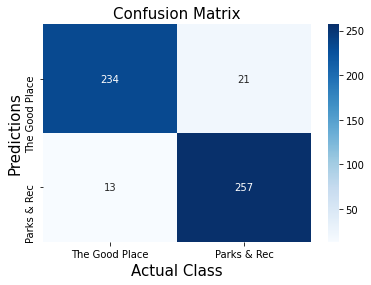

In [95]:
sns.heatmap(cm_df, annot = True, fmt = 'g', cmap = 'Blues')
plt.title('Confusion Matrix', size = 15)
plt.ylabel('Predictions', size = 15)
plt.xlabel('Actual Class', size = 15);

In [96]:
accuracy = (tp + tn)/(tp+fn+fp+tn)
print(f'Accuracy Rate: {accuracy}')

sensitivity = tp/(tp+fn)
print(f'Sensitivity Rate: {sensitivity}')
            
specificity = tn/(tn+fp)
print(f'Specificity Rate: {specificity}')

precision = tp/(tp+fp)
print(f'Precision Rate: {precision}')

true_neg = tn/(tn+fn)
print(f'True Negative Rate: {true_neg}')

Accuracy Rate: 0.9352380952380952
Sensitivity Rate: 0.9518518518518518
Specificity Rate: 0.9176470588235294
Precision Rate: 0.9244604316546763
True Negative Rate: 0.9473684210526315


Our accuracy rate states that 94% of all predictions the model made were correct.

Our sensitivity rate states that 95% of the time that a row was in the Parks & Rec subreddit, our model was able to predict the row correctly.

Our specificity rate states that 92% of the time that a row was not in the Parks & Rec subreddit, our model was able to predict the row correctly.  Since Parks & Rec was our majority class, I'm not surprised to see that our model had greater sensitivity than specificity, given the sensitivity/specificity tradeoff.

Our precision rate states that out of all the times our model predicted our majority class (Parks & Rec), our model was correct 92% of the time.

Our true negative rate states that out of all the times our model predicted our minority class (The Good Place), our model was correct 95% of the time.

Now, I want to be able to evaluate the coeffiecients to get a sense as to what terms give the model its greatest predictive power.

In [97]:
coef_df = {
    "column" : lr_fit.best_estimator_.steps[0][1].get_feature_names(), 
    "coef"   : lr_fit.best_estimator_.steps[2][1].coef_

}

In [98]:
lr_fit.best_estimator_.steps[0][1].get_feature_names()

['00',
 '000',
 '0000',
 '00pm',
 '01',
 '02',
 '021b522cd30caed14d644041db53a4ec',
 '0275ad358fe747cae7ad2fdbb8bda1a3',
 '03x12',
 '04',
 '045c1aa1b90f61f6f712df4d0b90d62c',
 '05',
 '0583',
 '06',
 '08',
 '09',
 '0edipamaas',
 '10',
 '100',
 '1000',
 '1000x500',
 '1003',
 '100lbs',
 '100x',
 '101',
 '104',
 '108',
 '1080p',
 '109',
 '10hr',
 '10jatk',
 '10th',
 '11',
 '110',
 '11am',
 '11th',
 '12',
 '1201869241',
 '121',
 '122',
 '12358w',
 '123889331',
 '125',
 '128',
 '13',
 '136',
 '1373996494',
 '13dtre1okb0',
 '13mins',
 '14',
 '146',
 '14thyear',
 '15',
 '150',
 '1500',
 '151',
 '1518',
 '1520',
 '154',
 '159',
 '16',
 '1650',
 '17',
 '18',
 '1800s',
 '181188768',
 '1865',
 '19',
 '1926',
 '1944',
 '1945',
 '1972',
 '1996',
 '1997',
 '1ksupport',
 '1nqtif',
 '1o2oredoblueo',
 '1st',
 '1u1',
 '1x10',
 '20',
 '200',
 '2002',
 '2009',
 '201',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '20160919173629',
 '2017',
 '2018',
 '202',
 '2043',
 '208327',
 '20and',
 '

In [99]:
lr_fit.best_estimator_.steps[2][1].coef_

array([[-1.83621655,  7.07615851, -0.22590275, ...,  6.27333222,
         6.27333222,  6.27333222]])

In [100]:
coefs = lr_fit.best_estimator_.steps[2][1].coef_ # getting coefficients
cols = lr_fit.best_estimator_.steps[0][1].get_feature_names() # getting column names
cols = pd.Series(cols) # turn into series
coefs = coefs[0]
feature_coefs = pd.DataFrame(coefs, index=cols) # put in data frame



In [101]:
feature_coefs.columns = ['coefficient']
feature_coefs['odds'] = np.exp(feature_coefs['coefficient'])
top_pr_coefs = feature_coefs.sort_values('coefficient',ascending=False).head(15) # top 15 features for Parks & Rec
top_gp_coefs = feature_coefs.sort_values('coefficient',ascending=False).tail(15) # top 15 features for The Good Place

In [102]:
top_gp_coefs.sort_values(by = 'coefficient')

,coefficient,odds
place,-153.537635,2.086664e-67
michael,-138.611601,6.335000e-61
eleanor,-116.033632,4.047937e-51
janet,-106.214002,7.444661e-47
good,-103.724942,8.970773e-46
chidi,-94.554072,8.623596e-42
jason,-75.325480,1.934460e-33
bad,-71.672073,7.468171e-32
tahani,-65.772156,2.725935e-29
tgp,-50.499172,1.170815e-22


Since The Good Place is the 0 in our binomial, strong coeffiecients will be the most negative coefficients.  This was sorted for better readability. 

In [103]:
top_pr_coefs

,coefficient,odds
leslie,120.701440,2.630081e+52
ron,94.380753,9.750803e+40
andy,79.163195,2.399599e+34
parks,74.829885,3.149244e+32
ben,67.144436,1.446965e+29
tom,59.661110,8.137500e+25
rec,59.203671,5.150243e+25
april,56.106797,2.327408e+24
ann,45.684276,6.925148e+19
jerry,45.139939,4.018154e+19


Most of the impactful coefficients unsurprisingly lined up with a character's name.  For example, if the main character of Parks & Rec, Leslie, was in a row, that row was over 2.630081 sexdecillion more likely to belong to Parks & Rec.  Our strongest coefficient for a Good Place character, Michael, states that a row containing his name was over 6.335000 novemdecillion times more likely to be classified as belonging to the Good Place (which was pretty much the same odds as getting sent to the bad place in the show).

Considering the model seemed to have mostly classified the characters correctly, I want to look further into my misclassifications, so I can start coming up with my show ideas.

In [104]:
y_test.loc[y_test != lr_preds].index #shows me misclassified rows

Int64Index([1371,  100, 1637, 1117, 1186, 1607,  933, 1517,  514, 1438, 1243,
            1624, 1930, 1453,  923, 2075, 1156, 1210,  822, 1248,  349, 1698,
            1056, 1428,  214,  934, 2083, 1699, 1014, 1560,  418, 1600,  679,
             742],
           dtype='int64')

In [105]:
misclassified = X_test[[1371,  100, 1637, 1117, 1186, 1607,  933, 1517,  514, 1438, 1243,
            1624, 1930, 1453,  923, 2075,   70,  135, 1156,  572, 1210,  822,
            1248,  349, 1698, 1056, 1428,  214,  934, 2083, 1699, 1014, 1560,
             418, 1600,  679,  742]]

In [106]:
misclass_df = pd.DataFrame(misclassified)

In [107]:
misclass_df.columns

Index(['all_text'], dtype='object')

In [108]:
misclass_df

,all_text
1371,Season 3? Just finished binge watching this sh...
100,"If given the chance, would you rather be a mem..."
1637,Rewatch with my wife Just started a rewatch wi...
1117,Where can I find season three episodes 1-7? I ...
1186,"Hey fat dinks, does anyone know where to watch..."
1607,"Season 2 is airing on Netflix in Australia, Ir..."
933,Girlfriend likes her new nickname My girlfrien...
1517,Do we know when season 2 premieres? I just sta...
514,The cast in other shows? What are some good sh...
1438,Any ideas when season 2 will be out on Netflix...


In [109]:
misclassified

1371    Season 3? Just finished binge watching this sh...
100     If given the chance, would you rather be a mem...
1637    Rewatch with my wife Just started a rewatch wi...
1117    Where can I find season three episodes 1-7? I ...
1186    Hey fat dinks, does anyone know where to watch...
1607    Season 2 is airing on Netflix in Australia, Ir...
933     Girlfriend likes her new nickname My girlfrien...
1517    Do we know when season 2 premieres? I just sta...
514     The cast in other shows? What are some good sh...
1438    Any ideas when season 2 will be out on Netflix...
1243    What line do you constantly repeat in your eve...
1624    Anyone else find Denise hilarious? She's a gre...
1930    Episode discussion season 1 episode 9 Someone ...
1453    Adam Scott on season 2 Why no Scott? He was a ...
923     Can I start with the 2nd season without missin...
2075    Title card font Does anyone know the font that...
70      Appreciation for u/NightTrainDan Just some lov...
135     need a

In [110]:
fcvec = CountVectorizer(ngram_range= (1,2), stop_words='english')

In [111]:
fin_count = fcvec.fit_transform(misclassified)

In [112]:
fcvec.get_feature_names()

['05',
 '05 21',
 '10',
 '10 5th',
 '112',
 '112 episodes',
 '1st',
 '1st honest',
 '2014',
 '2014 05',
 '2015',
 '2015 http',
 '21',
 '21 parks',
 '2nd',
 '2nd loss',
 '2nd season',
 '32',
 '32 weeks',
 '5th',
 '5th time',
 '71hjl4',
 '71hjl4 yet_another_theory',
 '80113701',
 '80113701 ll',
 'able',
 'able watch',
 'absolutely',
 'absolutely love',
 'account',
 'account favorite',
 'account jinmeister',
 'account posts',
 'account tweets',
 'actors',
 'actors outside',
 'actress',
 'actress steals',
 'actually',
 'actually thinking',
 'adam',
 'adam scott',
 'adventure',
 'adventure sure',
 'afford',
 'afford pay',
 'air',
 'air averages',
 'air know',
 'airing',
 'airing netflix',
 'airs',
 'airs watch',
 'alive',
 'alive support',
 'alive want',
 'alternative',
 'alternative badanimaldrawing',
 'america',
 'america megaphone',
 'amp',
 'amp crew',
 'amp pawntakesrook',
 'amp really',
 'andy',
 'andy realizes',
 'angst',
 'angst reliving',
 'anti',
 'anti spoiler',
 'antsy',
 'antsy

In [113]:
wrong_df = pd.DataFrame(fin_count.toarray(),
                      columns = fcvec.get_feature_names())

wrong_df.head()

,05,05 21,10,10 5th,112,112 episodes,1st,1st honest,2014,2014 05,...,years,years life,years posting,yet_another_theory,yet_another_theory gonwin,yo,yo self,youarenotbook,zealand,zealand uk
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [114]:
wrong_words = wrong_df.sum().sort_values(ascending = False).head(100)

In [115]:
common_mis = pd.DataFrame(wrong_words.head(25))

In [116]:
common_mis.columns = ['Word Usage']

In [117]:
common_mis

,Word Usage
season,30
episode,10
know,10
just,9
new,9
netflix,8
think,8
deleted,8
week,7
watch,7


Season, episode, and know were the least predictive terms in the model, with season and episode appearing in their plural forms as well.  This is no surprise, given that fans of both shows would likely refer to a specific season or episode in a post without specifically referencing the show itself.  The reference is assumed because it is already being posted on the specific Subreddit, so there's no need to talk about Season 1 of Parks & Rec, when you can just say Season 1 and everyone already knows what show you're referring to.  Although, there is no need to talk about the #brendanaquits seasons of Parks & Rec anyway.

In [118]:
wrong_words.index

Index(['season', 'episode', 'know', 'just', 'new', 'netflix', 'think',
       'deleted', 'week', 'watch', 'll', 'time', 'watching', 'favorite',
       'love', 'guys', 'great', 'com', 'like', 'does', 'episodes', 'gif',
       'want', 'season episode', 'entire', 'don', 'make', 'going', 'account',
       'final', 'sure', 'good', 'really', 'scene', 'started', 'http', 'having',
       'amp', 'watched', 'rewatch', 'post', 'funny', 'premiere', 'guys think',
       'probably', 'shows', 'people', 'discussion', 'use', 'hulu', 'past',
       'things', 'twitter', 'nighttraindan', 'title', 'got', 'cast', 'thought',
       'spoiler', 'gifs', 'lot', 'face', 'final season', 'alive', 'online',
       'work', 'parks', 'did', 'card', 'thinking', 'feel', 'im', 'thread',
       'luck', 'little', 'bot', 'loved', 'does know', 'binge', 'don know',
       'title card', 'link', 'given', 'girlfriend', 'makes', 'twitter account',
       'nickname', 'chance', 'features', 'new nickname', 'years', 'support',
       

# Conclusion

The Support Vector Machine model scored between 90-95% on accuracy, so we were able to achieve our modeling goal from a statistical standpoint, however writing comedies is hard.  This model can't necessarily guarantee a successful pilot.  A lot of the overlap happens on words that still aren't overly descriptive towards themes, but let's give this a shot.

From my first test
* Interestingly the model seems to misfire on scouts, so I think my show would have to do with campers or talent scouts.  Song is another word the model misfires on.  The words hilarious, actress, charity, and podcast also appear.  Yes, I see it now- the lead is a hilarious struggling actress named Charity, who gets casted on a singing show by Don, the talent scout for the show, who fell in love with our leading actress at first sight, and offered her a spot on his show without hearing her sing, so he can be around her.  Will Don's "charity offer" to cast a struggling actress, also named Charity, professionally and romanticly pay off?  If she can't sing, Don's career is over.  If Charity discovers Don's motivations, will she get disgusted and leave the show altogether?  Last thing, Don is British (UK and England are also stopwords).

From my second test
* The main character is still an Englishman named Don, who has a Twitter account and podcast called "Guys Think."  He is a leading voice for the trying too hard to be overly masculine (basically a British Joe Rogan).  His family tells him it's time for him to settle down and find a girlfriend, and as he tries, he struggles with his own masculinity when finding out that attractive women don't take kindly to his "manliness."  He interviews a sensitive guy named Scott, a seemingly plain guy with a beautiful, intelligent, and famous wife (think Melissa Mayer, who can probably also be played by Kristen Bell).  While he goes onto the attack during the interview, Don finds that Scott may be the type of guy he needs to keep around instead of his "macho" friends.  Scott is wary, but is too good of a guy to not help (basically Chidi from the Good Place).

These do seem like fun ideas to develop.  If we're truly judging our goal in a non-metric sense, this did generate an idea that my comedic ineptitude wouldn't have discovered on its own.  Now I just need to develop the characters and pitch it to Mike Schur.

## Next Steps

If I were to implement this further and look for even more ideas, I would probably run a decision tree model and possibly try a bootstrapping and bagging method (which I wasn't able to due to time constraints).  Additionally, I might look deeper into which rows misclassified and adjust my stopwords to improve accuracy.  I could even look to scrape more subreddits and attempt to classify new Subreddits in addition to The Good Place and Parks & Rec.  If I do that, I would likely have to rely more on boosting, bagging, and bootstrapping since I would be running classification on more than one target variable.

All of this would likely result in a more accurate model, but once again, I don't want to be too accurate because then I wouldn't be left with many words to generate ideas.

# References

- [Parks & Rec Subreddit](https://www.reddit.com/r/PandR/)
- [The Good Place Subreddit](https://www.reddit.com/r/TheGoodPlace/)
- [Data Dictionary for Original Data Categories](https://pushshift.io/api-parameters/)
